In [352]:
import numpy as np
from Data import ExperimentData, AntData, InteractionData, ForagerData
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from scipy.optimize import curve_fit

## Load data

In [2]:
exp11 = ExperimentData(11, bdata_path='blob analysis normalized by white paper')
BDATA = exp11.bdata
FEEDINGS = exp11.feedings_df
INTERACTONS = exp11.interactions_df
CLEAN_CROPS = exp11.clean_crops

## Find long measurement chunks

In [3]:
get_num_measurements = lambda x: np.sum(~np.isnan(x))

In [341]:
def get_large_measurement_chunks_ant(ant, low_threshold=400): #, high_threshold=400):
    large_measurement_chunks = {'red':[], 'yellow':[]}
    clean_crop = {'red':[], 'yellow':[]}
    for idx, trop_row in ant.interactions_df.iterrows():
        trop = InteractionData(trop_row, BDATA, CLEAN_CROPS, max(CLEAN_CROPS.index))
        raw_measurements = trop.get_ant_measurements_before_or_after(str(ant_id), BDATA, CLEAN_CROPS, 'after')
        n = InteractionData.rate_measurements(raw_measurements, get_num_measurements)
        for color in ['red','yellow']:
            if (n[color]>=low_threshold): # & (n[color]<=high_threshold):
                large_measurement_chunks[color].append(raw_measurements[color])
                
                ant_crop_before, ant_got = trop.get_ant_measurement(str(ant_id),CLEAN_CROPS)
                crop_estimate = ant_crop_before+ant_got
                clean_crop[color].append(crop_estimate[color])
                
    if large_measurement_chunks:
        return large_measurement_chunks, clean_crop

In [342]:
large_measurement_chunks_all = {'red':[],'yellow':[]}
clean_crop_all = {'red':[],'yellow':[]}
for ant_id in exp11.ants_list:
    if ant_id in exp11.foragers_list:
        ant = ForagerData(ant_id, exp11.feedings_df, exp11.bdata, exp11.interactions_df)
    else:
        ant = AntData(ant_id, exp11.bdata, exp11.interactions_df)
    
    large_measurement_chunks_ant, clean_crop_ant = get_large_measurement_chunks_ant(ant)
    
    for color in ['red','yellow']:
        if large_measurement_chunks_ant[color]:
            large_measurement_chunks_all[color].extend(large_measurement_chunks_ant[color])
            clean_crop_all[color].extend(clean_crop_ant[color])
    

In [343]:
len(large_measurement_chunks_all['yellow'])

65

## Calculate sum of squares from mean/95th percentile

In [380]:
def get_sample_size_dependent_difference(measurements, threshold=300):
    measurements = (measurements-np.mean(measurements))/np.std(measurements)
    final_estimate = np.percentile(measurements,95)
    differences = {}
    for sample_size in range(threshold): #range(len(measurements)):
        sample = measurements.iloc[0:sample_size]
        if not sample.empty:
            sample_estimate = np.percentile(sample,95)
        else:
            sample_estimate=np.nan
        differences[sample_size] = sample_estimate - final_estimate
    differences_df = pd.DataFrame.from_dict(differences, orient='index')
    return differences_df

In [381]:
list_of_differences = []
for chunk in large_measurement_chunks_all['red']:
    measurements = chunk[~chunk.isna()]
    differences_chunk = get_sample_size_dependent_difference(measurements)
    list_of_differences.append(differences_chunk)
differences_all = pd.concat(list_of_differences, axis=1)


In [382]:
differences_all

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1.073286,-0.811465,-0.454966,-2.742005,-2.491854,-1.605543,-3.131191,-2.112306,-4.576237,-4.576237,...,-2.659777,-0.007979,0.405619,-1.358270,-0.869530,-2.541660,0.779233,-0.357506,-2.881044,-2.919878
2,-1.000285,-0.836338,-0.461919,-1.462753,-2.491854,-1.649160,-3.049291,-1.092102,-4.576237,-4.576237,...,-2.051651,2.211740,0.749859,-0.663079,-0.869530,-2.567023,1.041193,-0.360722,-2.932306,-2.919878
3,-1.004128,-0.831651,-0.462770,-1.470474,-2.491854,-1.692776,-3.053601,-1.145797,-4.576237,-4.576237,...,-2.052568,2.313091,0.819173,-0.667230,-0.869530,-2.592387,1.141856,-0.179427,-2.983567,-2.919878
4,-1.007970,-0.767686,-0.466673,-1.507998,-2.491854,-1.642532,-3.057912,-1.199492,-4.576237,-4.576237,...,-2.069030,2.305353,0.816329,-0.528859,-0.441815,-2.565432,2.475335,-0.148093,-3.029089,-2.844608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.204096,-0.425790,0.554694,0.076003,-2.491854,0.215422,-2.567691,0.294093,-0.240747,-0.240747,...,-0.514130,0.373792,0.802902,-0.155755,-0.481561,0.127065,-0.068357,-0.063131,0.047052,-2.790465
296,0.201846,-0.426092,0.542743,0.075909,-2.491854,0.213517,-2.567771,0.292812,-0.221285,-0.221285,...,-0.514654,0.373536,0.801681,-0.155960,-0.484221,0.124567,-0.062331,-0.054217,0.046965,-2.790497
297,0.199595,-0.426393,0.530792,0.075815,-2.491854,0.211612,-2.567851,0.291530,-0.214047,-0.214047,...,-0.515178,0.373280,0.800460,-0.156164,-0.486881,0.122069,-0.053535,-0.054521,0.046878,-2.790529
298,0.197345,-0.426695,0.518840,0.075721,-2.491854,0.209707,-2.567931,0.290249,-0.203783,-0.203783,...,-0.515702,0.373024,0.799239,-0.156369,-0.489541,0.119571,-0.054320,-0.054826,0.046791,-2.790561


In [383]:
#result_mean = SSD_all.apply(np.mean, axis=1)
#result_ste = SSD_all.apply(lambda x: stats.sem(x, nan_policy='omit'), axis=1)
sum_of_squares = differences_all.apply(lambda x: np.sum(x**2), axis=1)
sum_of_squares

0        0.000000
1      321.021160
2      284.926063
3      268.838730
4      315.269825
          ...    
295     36.309093
296     36.154695
297     36.417018
298     36.334557
299     36.271413
Length: 300, dtype: float64

Text(0, 0.5, 'sum of squares from actual estimate')

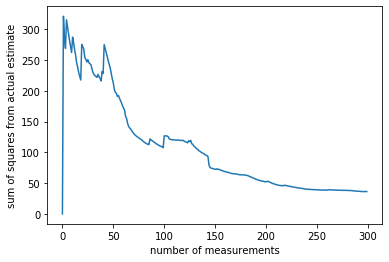

In [384]:
plt.plot(sum_of_squares)
#plt.fill_between(result_ste.index, (result_mean-result_ste), (result_mean+result_ste), color='b', alpha=.1)
#plt.xlim([0,405])
#plt.ylim([1,50])
plt.xlabel('number of measurements')
plt.ylabel('sum of squares from actual estimate')

Text(0, 0.5, 'confidence')

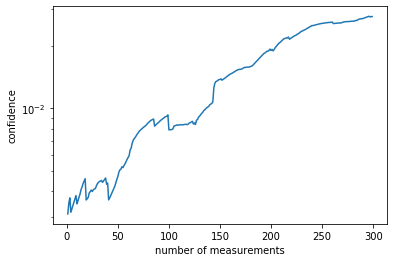

In [385]:
plt.plot(1/sum_of_squares)
plt.yscale('log')
#plt.ylim([0,1])
#plt.xlim([0,500])
plt.xlabel('number of measurements')
plt.ylabel('confidence')

C:\Users\liorba\Anaconda3\envs\Experimenting\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


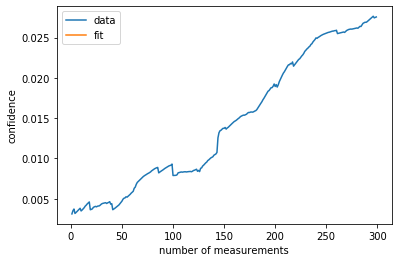

In [386]:
x = sum_of_squares.index.to_list()
y = 1/sum_of_squares.values
#x = x[1:350]
#y = y[1:350]
logy = np.log(y)
coeffs = np.polyfit(x,logy,1)
poly = np.poly1d(coeffs)
yfit = lambda x: np.exp(poly(x))
plt.plot(x,y)
plt.plot(x,yfit(x))
plt.xlabel('number of measurements')
plt.ylabel('confidence')
plt.legend(['data','fit'])

In [387]:
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)

p0 = [max(y[1:]), np.median(x[1:]),1,min(y[1:])] # this is an mandatory initial guess

popt, pcov = curve_fit(sigmoid, x[1:], y[1:], p0, method='dogbox')

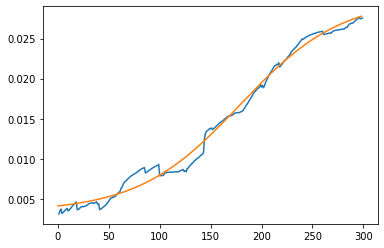

In [388]:
plt.plot(x,y)
plt.plot(sigmoid(x[1:],popt[0],popt[1],popt[2],popt[3]))

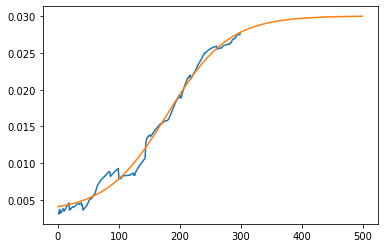

In [389]:
plt.plot(x,y)
plt.plot(sigmoid(np.arange(500),popt[0],popt[1],popt[2],popt[3]))

Text(0, 0.5, 'confidence')

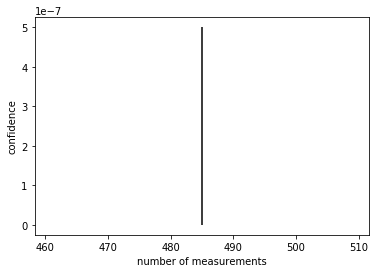

In [340]:
plt.plot(np.arange(500), yfit(np.arange(500)))
plt.vlines(485,0,5*(10**(-7)))
plt.xlabel('number of measurements')
plt.ylabel('confidence')

In [281]:
yfit(485)

3.0433004795396004e-07

In [232]:
poly

poly1d([ 0.02028383, -7.40959574])

In [64]:
chunk = large_measurement_chunks_all['red'][13]
chunk_measurements = chunk[~chunk.isna()]
total_mean = np.mean(chunk_measurements)
SSD = {}
for sample_size in range(len(chunk_measurements)):
    sample = chunk_measurements.iloc[0:sample_size]
    SSD[sample_size] = np.sum((sample-total_mean)**2)
SSD_df = pd.DataFrame.from_dict(SSD, orient='index')
SSD_df

,0
0,0.000000e+00
1,5.512698e+07
2,5.775960e+07
3,8.346722e+07
4,1.478758e+08
...,...
996,1.303525e+11
997,1.306330e+11
998,1.307532e+11
999,1.310521e+11


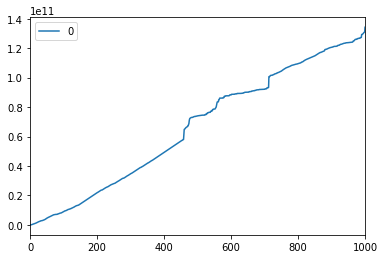

In [65]:
SSD_df.plot()

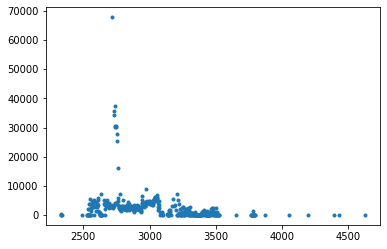

In [11]:
chunk = large_measurement_chunks_all['red'][0]
plt.plot(chunk,'.')

In [12]:
clean_crop_all['red'][0]

3909.2561645507812

In [ ]:
get_large_measurement_chunks_ant(ant)

In [13]:
len(large_measurement_chunks_all['red'])

564

In [14]:
len(clean_crop_all['red'])

564